## CAF NSCLC paper

Downstream image analysis notebook for manuscript "Identification of two novel subsets of multi-marker-defined cancer-associated fibroblasts in non-small cell lung cancer with inverse associations to immune features, driver mutations, and survival" by Pellinen T. et al. (2022).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Paths and files
rootpath = Path('BOMI2')
respath = Path('BOMI2_results')
bomi = 'BOMI2'
featpat = '_features.csv'
bgregion = 'panepi'
files = sorted(rootpath.glob('*'+featpat))
# Channel file name mapping
if bomi=='BOMI2':
    channel_map = {'DAPI': '1B', 'PDGFRB': '1G', 'PDGFRA': '1O', 'FAP': '1R', 'SMA': '1V', 'PanEpiMask': '1B_PanEpiMask'}
else:
    channel_map = {'DAPI': 'DAPI_ORG', 'PDGFRB': 'AF488_ORG', 'PDGFRA': 'AF555_ORG', 'FAP': 'AF750_ORG', 'SMA': 'AF647_ORG', 'PanEpiMask': 'PanEpiMask'}

In [3]:
# General settings
panepimask_threshold = 0.25
dist = 100
channels = ['FAP', 'PDGFRA', 'PDGFRB', 'SMA']
# Set positivity threshold mean + x * std
thrmult = {'FAP': 1.0, 'PDGFRA': 1.0, 'PDGFRB': 1.0, 'SMA': 1.0, 'PanEpiMask': 0.0}
if bomi=='BOMI1':
    thrmult['PDGFRB'] = 2.0

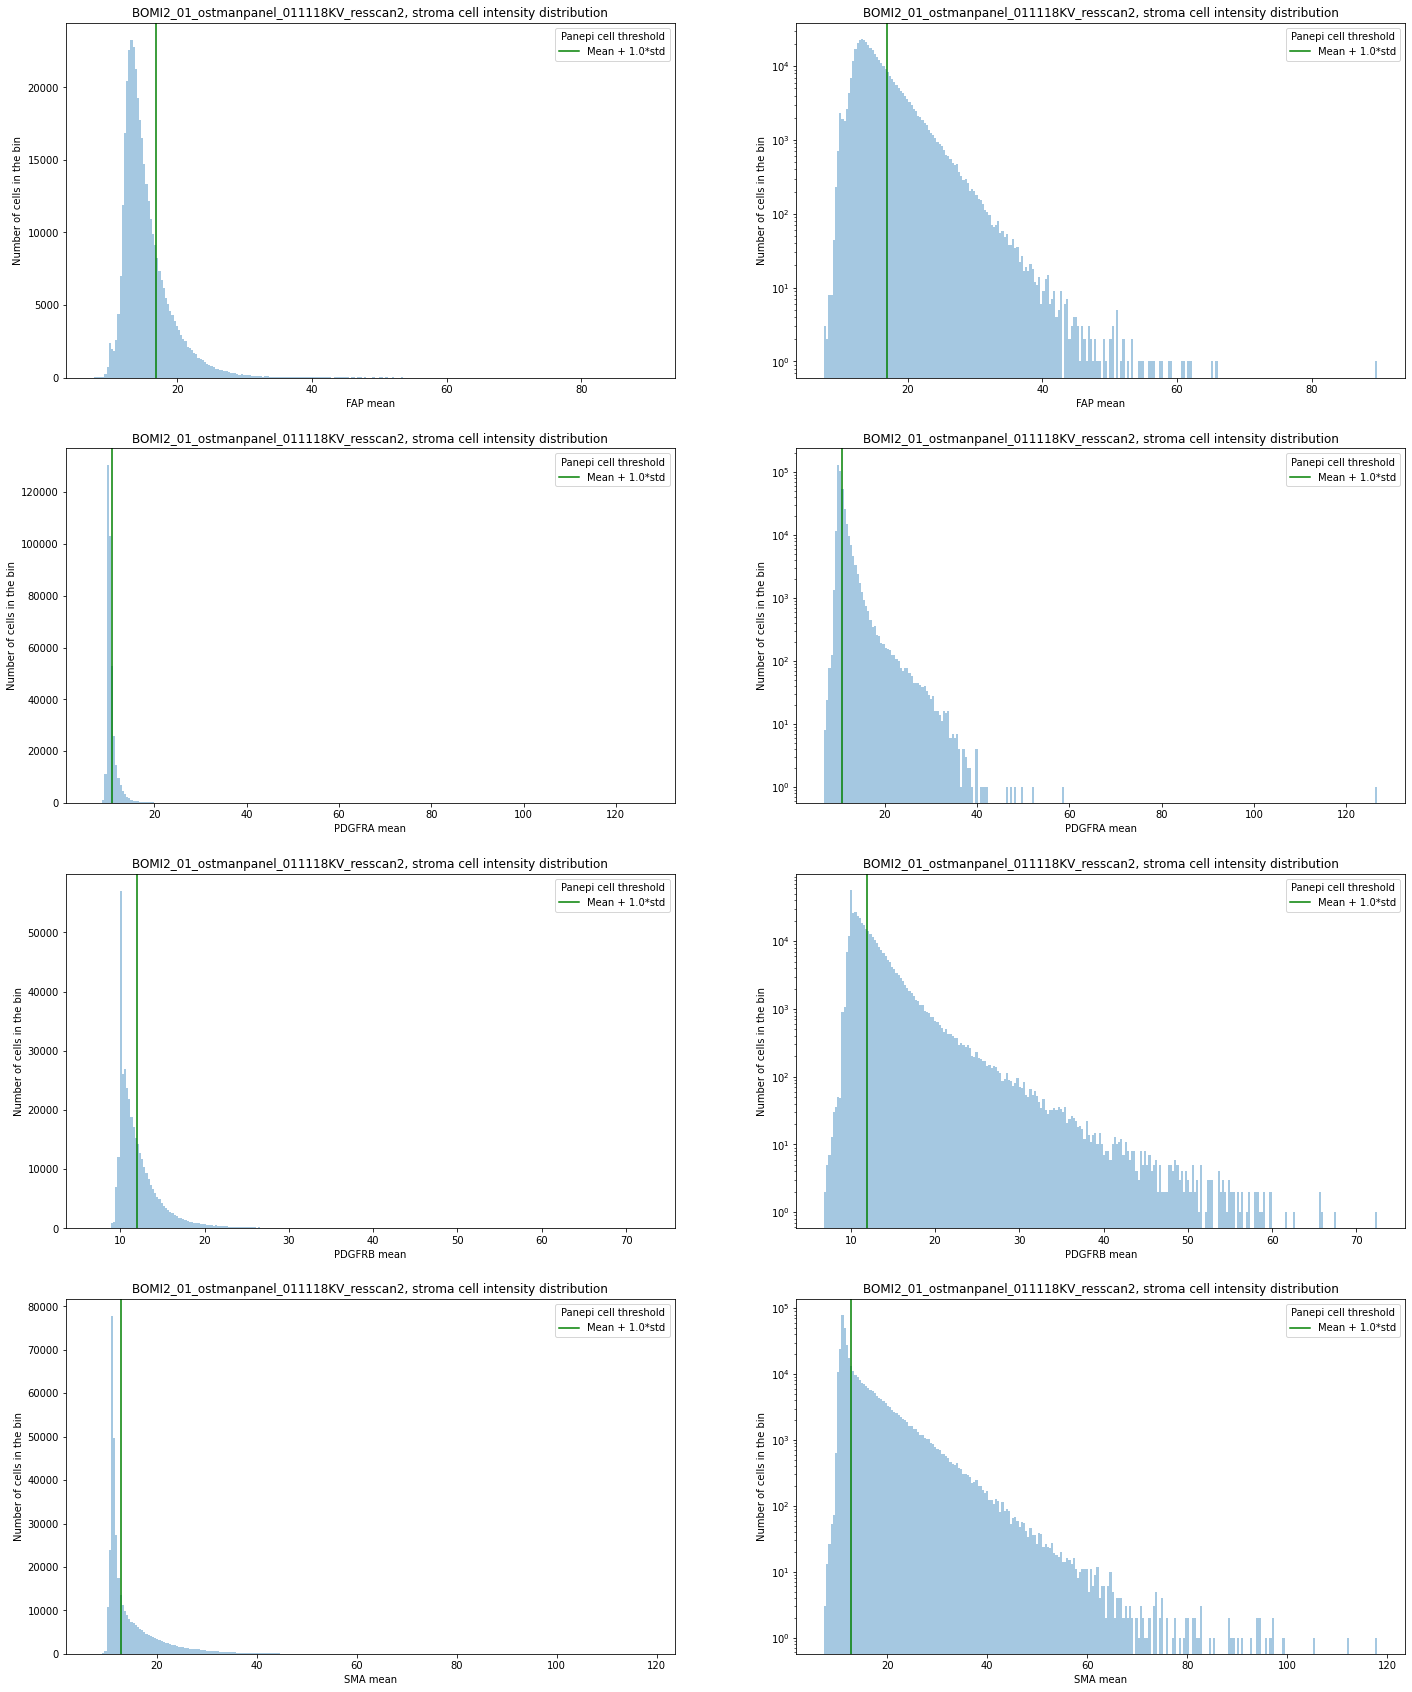

In [4]:
# Plot the first glass
featfile = files[0]
glass = featfile.name.split(featpat)[0]
df = pd.read_csv(featfile)

# Select panepi cells for thresholding
sdf = df[df['PanEpiMask_mean']>=panepimask_threshold]

# Calculate mean and stdev intensities for each channel
aggstats = pd.DataFrame(data={'mean': [0.0]*len(channels), 'stdev': [0.0]*len(channels)}, index=channels)
aggstats.index.name = 'channel'
for ch in channels:
    aggstats.loc[ch,'mean'] = sdf['{}_mean'.format(ch)].mean()
    aggstats.loc[ch,'stdev'] = np.std(sdf['{}_mean'.format(ch)])

# Select stroma cells for histograms
pdf = df[df['PanEpiMask_mean']<panepimask_threshold]

fig,axs = plt.subplots(len(channels), 2, figsize=(24,30))
for i,ch in enumerate(channels):
    for j in range(2):
        ax = axs[i,j]
        sns.distplot(pdf[ch+'_mean'], kde=False, bins=256, ax=ax)
        ax.axvline(aggstats.loc[ch, 'mean'] + thrmult[ch]*aggstats.loc[ch, 'stdev'], color='green')
        ax.legend(title='Panepi cell threshold', labels=['Mean + {:.1f}*std'.format(thrmult[ch])])
        axtitle = "{}, stroma cell intensity distribution".format(glass)
        ax.set_title(axtitle)
        ax.set_xlabel('{} mean'.format(ch))
        ax.set_ylabel('Number of cells in the bin')
        if j==1:
            ax.set_yscale('log')
    
fig.savefig(respath / 'plots/{}.png'.format(bgregion))

## Measure all combinations of positivity

In [5]:
resdfs_stroma = []
resdfs_juxta = []
resdfs_dista = []
threshold = 'mean'
for featfile in files:
    glass = featfile.name.split(featpat)[0]
    df = pd.read_csv(featfile)
    
    # 1. mean + x*std from all cells in panepi region
    aggstats = pd.DataFrame(data={'mean': [0.0]*len(channels), 'stdev': [0.0]*len(channels)}, index=channels)
    aggstats.index.name = 'channel'
    for ch in channels:
        aggstats.loc[ch,'mean'] = df.loc[df['PanEpiMask_mean']>=panepimask_threshold, '{}_mean'.format(ch)].mean()
        aggstats.loc[ch,'stdev'] = np.std(df.loc[df['PanEpiMask_mean']>=panepimask_threshold, '{}_mean'.format(ch)])

    aggstats.loc['PanEpiMask', 'mean'] = panepimask_threshold # Set PanEpiMask threshold
    aggstats.loc['PanEpiMask', 'stdev'] = 0.0 # Set PanEpiMask threshold
    
    thrcols = ['glass', 'spot', 'cells']
    thrdf = df.copy()
    thrdf['cells'] = 1
    ########## Work with subsets ##########
    thrdf_stroma = thrdf[thrdf['PanEpiMask_mean']<panepimask_threshold].copy()
    thrdf_juxta = thrdf[(thrdf['PanEpiMask_dist_mean']>0)&(thrdf['PanEpiMask_dist_mean']<=dist)].copy()
    thrdf_dista = thrdf[thrdf['PanEpiMask_dist_mean']>dist].copy()
    #######################################
    
    for ch in channels:
        thrcol = ch+'_'+threshold
        thrcols.append(ch)
        thrdf_stroma[ch] = thrdf_stroma.loc[:,thrcol] > (aggstats.loc[ch,threshold] + thrmult[ch] * aggstats.loc[ch,'stdev'])
        thrdf_juxta[ch] = thrdf_juxta.loc[:,thrcol] > (aggstats.loc[ch,threshold] + thrmult[ch] * aggstats.loc[ch,'stdev'])
        thrdf_dista[ch] = thrdf_dista.loc[:,thrcol] > (aggstats.loc[ch,threshold] + thrmult[ch] * aggstats.loc[ch,'stdev'])
    thrdf_stroma = thrdf_stroma[thrcols]
    thrdf_juxta = thrdf_juxta[thrcols]
    thrdf_dista = thrdf_dista[thrcols]
    
    outcols = ['cells']
    for k in range(1,len(channels)+1):
        for comb in itertools.combinations([x+'+' for x in channels] + [x+'-' for x in channels],k):
            # Check that comb does not have the same marker as + and -
            unsigned = [x[:-1] for x in comb]
            if len(unsigned) != len(list(set(unsigned))):
                continue
            
            comb_str = ''.join(comb) + 'PanEpiMask-'
            outcols.append(comb_str)
            comb_pos = np.logical_and.reduce([(thrdf_stroma[pos[:-1]]==True if pos[-1]=='+' else thrdf_stroma[pos[:-1]]==False) for pos in comb])
            thrdf_stroma[comb_str] = comb_pos
            comb_pos = np.logical_and.reduce([(thrdf_juxta[pos[:-1]]==True if pos[-1]=='+' else thrdf_juxta[pos[:-1]]==False) for pos in comb])
            thrdf_juxta[comb_str] = comb_pos
            comb_pos = np.logical_and.reduce([(thrdf_dista[pos[:-1]]==True if pos[-1]=='+' else thrdf_dista[pos[:-1]]==False) for pos in comb])
            thrdf_dista[comb_str] = comb_pos
            
    thrdf_stroma = thrdf_stroma.groupby(['glass','spot']).aggregate(np.sum)
    resdfs_stroma.append(thrdf_stroma[outcols])
    thrdf_juxta = thrdf_juxta.groupby(['glass','spot']).aggregate(np.sum)
    resdfs_juxta.append(thrdf_juxta[outcols])
    thrdf_dista = thrdf_dista.groupby(['glass','spot']).aggregate(np.sum)
    resdfs_dista.append(thrdf_dista[outcols])

# Save results
resdf = pd.concat(resdfs_stroma)
resdf.to_csv(respath / '{}_phenotype_counts_threshold_region_{}.csv'.format(bomi,bgregion))
resdf.iloc[:,1:] = resdf.iloc[:,1:].div(resdf.loc[:,'cells'], axis=0)
resdf.to_csv(respath / '{}_phenotype_ratios_threshold_region_{}.csv'.format(bomi,bgregion))

resdf = pd.concat(resdfs_juxta)
resdf.to_csv(respath / '{}_phenotype_counts_threshold_region_{}_panepidist_0-{}.csv'.format(bomi,bgregion,dist))
resdf.iloc[:,1:] = resdf.iloc[:,1:].div(resdf.loc[:,'cells'], axis=0)
resdf.to_csv(respath / '{}_phenotype_ratios_threshold_region_{}_panepidist_0-{}.csv'.format(bomi,bgregion,dist))

resdf = pd.concat(resdfs_dista)
resdf.to_csv(respath / '{}_phenotype_counts_threshold_region_{}_panepidist_{}+.csv'.format(bomi,bgregion,dist))
resdf.iloc[:,1:] = resdf.iloc[:,1:].div(resdf.loc[:,'cells'], axis=0)
resdf.to_csv(respath / '{}_phenotype_ratios_threshold_region_{}_panepidist_{}+.csv'.format(bomi,bgregion,dist))

## Measure fixed 15 combinations

In [6]:
fixedcomb = [(a,b,c,d) for a in ['PDGFRA-','PDGFRA+'] for b in ['PDGFRB-','PDGFRB+'] for c in ['FAP-','FAP+'] for d in ['SMA-','SMA+']]
fixedcomb = [(a,b,c,d,'PanEpiMask-') for a,b,c,d in fixedcomb]
# Drop quadruple negative
fixedcomb = fixedcomb[1:]

In [7]:
resdfs_stroma = []
resdfs_juxta = []
resdfs_dista = []
threshold = 'mean'
for featfile in files:
    glass = featfile.name.split(featpat)[0]
    df = pd.read_csv(featfile)
    
    # Calculate thresholds as mean + x*std of all cells in panepi region for each channel
    aggstats = pd.DataFrame(data={'mean': [0.0]*len(channels), 'stdev': [0.0]*len(channels)}, index=channels)
    aggstats.index.name = 'channel'
    for ch in channels:
        aggstats.loc[ch,'mean'] = df.loc[df['PanEpiMask_mean']>=panepimask_threshold, '{}_mean'.format(ch)].mean()
        aggstats.loc[ch,'stdev'] = np.std(df.loc[df['PanEpiMask_mean']>=panepimask_threshold, '{}_mean'.format(ch)])

    aggstats.loc['PanEpiMask', 'mean'] = panepimask_threshold # Set PanEpiMask threshold
    aggstats.loc['PanEpiMask', 'stdev'] = 0.0 # Set PanEpiMask threshold
    
    thrcols = ['glass', 'spot', 'cells']
    thrdf = df.copy()
    thrdf['cells'] = 1
    ########## Work with subset ##########
    thrdf_stroma = thrdf[thrdf['PanEpiMask_mean']<panepimask_threshold].copy()
    thrdf_juxta = thrdf[(thrdf['PanEpiMask_dist_mean']>0)&(thrdf['PanEpiMask_dist_mean']<=dist)].copy()
    thrdf_dista = thrdf[thrdf['PanEpiMask_dist_mean']>dist].copy()
    ######################################
    
    for ch in channels + ['PanEpiMask']:
        thrcol = ch+'_'+threshold
        thrcols.append(ch)
        thrdf_stroma[ch] = thrdf_stroma.loc[:,thrcol] > (aggstats.loc[ch,threshold] + thrmult[ch]*aggstats.loc[ch,'stdev'])
        thrdf_juxta[ch] = thrdf_juxta.loc[:,thrcol] > (aggstats.loc[ch,threshold] + thrmult[ch]*aggstats.loc[ch,'stdev'])
        thrdf_dista[ch] = thrdf_dista.loc[:,thrcol] > (aggstats.loc[ch,threshold] + thrmult[ch]*aggstats.loc[ch,'stdev'])
    thrdf_stroma = thrdf_stroma[thrcols]
    thrdf_juxta = thrdf_juxta[thrcols]
    thrdf_dista = thrdf_dista[thrcols]
    
    outcols = ['cells']
    for comb in fixedcomb:
        comb_str = ''.join(comb)
        outcols.append(comb_str)
        comb_pos = np.logical_and.reduce([(thrdf_stroma[pos[:-1]]==True if pos[-1]=='+' else thrdf_stroma[pos[:-1]]==False) for pos in comb])
        thrdf_stroma[comb_str] = comb_pos
        comb_pos = np.logical_and.reduce([(thrdf_juxta[pos[:-1]]==True if pos[-1]=='+' else thrdf_juxta[pos[:-1]]==False) for pos in comb])
        thrdf_juxta[comb_str] = comb_pos
        comb_pos = np.logical_and.reduce([(thrdf_dista[pos[:-1]]==True if pos[-1]=='+' else thrdf_dista[pos[:-1]]==False) for pos in comb])
        thrdf_dista[comb_str] = comb_pos
        
    thrdf_stroma = thrdf_stroma.groupby(['glass','spot']).aggregate(np.sum)
    resdfs_stroma.append(thrdf_stroma[outcols])
    thrdf_juxta = thrdf_juxta.groupby(['glass','spot']).aggregate(np.sum)
    resdfs_juxta.append(thrdf_juxta[outcols])
    thrdf_dista = thrdf_dista.groupby(['glass','spot']).aggregate(np.sum)
    resdfs_dista.append(thrdf_dista[outcols])
    
resdf = pd.concat(resdfs_stroma)
resdf.to_csv(respath / '{}_15comb_counts_threshold_region_{}.csv'.format(bomi,bgregion))
resdf = pd.concat(resdfs_juxta)
resdf.to_csv(respath / '{}_15comb_counts_threshold_region_{}_panepidist_0-{}.csv'.format(bomi,bgregion,dist))
resdf = pd.concat(resdfs_dista)
resdf.to_csv(respath / '{}_15comb_counts_threshold_region_{}_panepidist_{}+.csv'.format(bomi,bgregion,dist))

In [8]:
# Create 15 combination ratios
for fpath in respath.glob('{}_15comb_counts*'.format(bomi)):
    df = pd.read_csv(fpath)
    # Normalize results
    norm = df.iloc[:,3:].sum(axis=1)
    df.iloc[:,3:] = df.iloc[:,3:].divide(norm, axis=0)
    df = df.drop(['cells'], axis=1)
    df.to_csv(fpath.as_posix().replace('15comb_counts','15comb_ratios'), index=False)